#**Imports**

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# XGBoost
from xgboost import XGBClassifier

# Unsupervised methods
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# For saving models
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("All imports complete.")


All imports complete.


# **Load Metadata & Raw Kidney Data**

In [3]:
metadata_file_path = "/content/kidey.txt"
column_names = []
with open(metadata_file_path, 'r') as file:
    next(file)  # Skip header line
    for line in file:
        parts = line.split('\t')
        if len(parts) > 1:
            column_names.append(parts[1].strip())
print(f"Extracted {len(column_names)} column names from metadata.")

# Load the raw dataset (e.g., KIDPAN_DATA.DAT) - adjust path if needed.
data_file_path = "/content/KIDPAN_DATA.DAT"
raw_data = pd.read_csv(data_file_path, sep='\t', header=None, engine='python')

if len(column_names) >= raw_data.shape[1]:
    raw_data.columns = column_names[:raw_data.shape[1]]
else:
    print("Warning: Not enough column names for all data columns.")

print("Raw data shape:", raw_data.shape)


Extracted 472 column names from metadata.
Raw data shape: (9081, 472)


# **Data Cleaning & Preprocessing**

In [4]:
# Replace dot values ('.') with NaN.
raw_data.replace(".", np.nan, inplace=True)

# Convert columns containing 'DATE' or 'DT' to datetime.
date_cols = [col for col in raw_data.columns if col and ('DATE' in col.upper() or 'DT' in col.upper())]
for col in date_cols:
    raw_data[col] = pd.to_datetime(raw_data[col], format='%m/%d/%Y', errors='coerce')

# Drop columns with >80% missing values.
missing_percentage = raw_data.isnull().mean() * 100
cols_to_drop = missing_percentage[missing_percentage > 80].index.tolist()
print(f"Number of columns to drop (>80% missing): {len(cols_to_drop)}")
data_cleaned = raw_data.drop(columns=cols_to_drop)
print("Shape after dropping high-missing columns:", data_cleaned.shape)

# Impute remaining missing values:
# - For numeric columns: use median.
# - For categorical columns: use mode.
data_imputed = data_cleaned.copy()
numeric_cols = data_imputed.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_imputed.select_dtypes(include=['object']).columns

for col in numeric_cols:
    if data_imputed[col].isnull().any():
        data_imputed[col].fillna(data_imputed[col].median(), inplace=True)
for col in categorical_cols:
    if data_imputed[col].isnull().any():
        data_imputed[col].fillna(data_imputed[col].mode()[0], inplace=True)

print("Total missing values after imputation:", data_imputed.isnull().sum().sum())


<ipython-input-4-fc3bc4c1bfb6>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_data.replace(".", np.nan, inplace=True)


Number of columns to drop (>80% missing): 392
Shape after dropping high-missing columns: (9081, 80)


<ipython-input-4-fc3bc4c1bfb6>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_imputed[col].fillna(data_imputed[col].median(), inplace=True)
<ipython-input-4-fc3bc4c1bfb6>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

Total missing values after imputation: 14081


# **Define Outcome Variable for Transplant Success**

In [5]:
# Here we define transplant success as 1 if COMPOSITE_DEATH_DATE is null (patient alive at follow‑up), 0 otherwise.
if 'COMPOSITE_DEATH_DATE' in data_imputed.columns:
    data_imputed['Transplant_Success'] = data_imputed['COMPOSITE_DEATH_DATE'].isnull().astype(int)
    print("Transplant_Success value counts:")
    print(data_imputed['Transplant_Success'].value_counts())
else:
    print("COMPOSITE_DEATH_DATE column not found. Verify your data.")


Transplant_Success value counts:
Transplant_Success
1    6903
0    2178
Name: count, dtype: int64


# **Unsupervised Clustering – Derive "Kidney_Cluster"**

In [6]:
def prepare_kidney_clustering(data_imputed, sample_size=5000):
    # Candidate features for clustering
    candidate_features = ['ABO', 'GFR', 'ON_DIALYSIS', 'INIT_AGE', 'BMI_TCR', 'DAYSWAIT_ALLOC']
    available_features = [col for col in candidate_features if col in data_imputed.columns]
    print("Candidate features available for clustering:", available_features)

    # Create a copy of the data to avoid modifying the original
    X_candidate = data_imputed[available_features].copy()

    # Convert columns to numeric where appropriate
    for col in ['GFR', 'INIT_AGE', 'BMI_TCR', 'DAYSWAIT_ALLOC']:
        if col in X_candidate.columns:
            X_candidate[col] = pd.to_numeric(X_candidate[col], errors='coerce')

    # Convert ON_DIALYSIS to numeric
    if 'ON_DIALYSIS' in X_candidate.columns:
        X_candidate['ON_DIALYSIS'] = X_candidate['ON_DIALYSIS'].map({'Y': 1, 'N': 0})

    # One-hot encode the ABO column
    if 'ABO' in X_candidate.columns:
        X_candidate = pd.get_dummies(X_candidate, columns=['ABO'], drop_first=True)

    # Drop rows with missing values to ensure consistent processing
    X_candidate = X_candidate.dropna()

    # Drop duplicate rows
    X_candidate = X_candidate.drop_duplicates()
    print("Candidate features shape after cleaning:", X_candidate.shape)

    # Scale candidate features
    scaler_candidate = StandardScaler()
    X_candidate_scaled = scaler_candidate.fit_transform(X_candidate)
    X_candidate_scaled_df = pd.DataFrame(X_candidate_scaled, columns=X_candidate.columns)

    # Sample for clustering if dataset is large
    if X_candidate_scaled_df.shape[0] > sample_size:
        X_sample = X_candidate_scaled_df.sample(n=sample_size, random_state=42)
    else:
        X_sample = X_candidate_scaled_df.copy()

    # Apply KMeans clustering
    kmeans_model = KMeans(n_clusters=2, random_state=42)
    kmeans_model.fit(X_sample)

    # Predict cluster labels for the sampled dataset
    sample_cluster_labels = kmeans_model.predict(X_sample)

    # Predict cluster labels for all data points
    all_cluster_labels = kmeans_model.predict(X_candidate_scaled_df)
    X_candidate_scaled_df['Cluster'] = all_cluster_labels

    # Create a mapping of original indices to cluster labels
    sample_indices = X_sample.index
    cluster_mapping = pd.Series(sample_cluster_labels, index=sample_indices)

    # Create a full-length cluster labels series with a default cluster
    full_cluster_labels = pd.Series(
        np.full(len(data_imputed), cluster_mapping.mode()[0]),
        index=data_imputed.index
    )

    # Update cluster labels for sampled data points
    full_cluster_labels.update(cluster_mapping)

    # Add cluster labels to the original dataframe
    data_imputed['Kidney_Cluster'] = full_cluster_labels

    print("Kidney_Cluster feature added. Sample:")
    print(data_imputed[['Kidney_Cluster']].head())

    # Save the scaler and clustering model
    joblib.dump(scaler_candidate, '/content/scaler_candidate_features.pkl')
    joblib.dump(kmeans_model, '/content/kmeans_model.pkl')

    return data_imputed, X_candidate_scaled_df

# Call the function
data_imputed, X_candidate_scaled_df = prepare_kidney_clustering(data_imputed)

Candidate features available for clustering: ['ABO', 'GFR', 'ON_DIALYSIS', 'INIT_AGE', 'BMI_TCR', 'DAYSWAIT_ALLOC']
Candidate features shape after cleaning: (8981, 11)
Kidney_Cluster feature added. Sample:
   Kidney_Cluster
0               1
1               0
2               0
3               0
4               0


# **Feature Engineering for Outcome Modeling**

In [7]:
# We now build a feature set for the outcome model.
# Base features: 'INIT_AGE', 'BMI_TCR', 'DAYSWAIT_ALLOC', 'Kidney_Cluster'
# Additional features (if available): 'WGT_KG_TCR', 'HGT_CM_TCR', 'DGN_TCR'
additional_features = ['WGT_KG_TCR', 'HGT_CM_TCR', 'DGN_TCR']
base_features = ['INIT_AGE', 'BMI_TCR', 'DAYSWAIT_ALLOC', 'Kidney_Cluster']
model_features = base_features + additional_features

# Ensure only available features are used.
available_model_features = [col for col in model_features if col in data_imputed.columns]
print("Selected features for modeling:", available_model_features)

# Create a DataFrame for modeling.
df_model = data_imputed[available_model_features].copy()

# Convert all selected features to numeric.
for col in available_model_features:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
df_model = df_model.fillna(df_model.median())

# Feature Engineering:
# 1. Interaction term: INIT_AGE x BMI_TCR.
df_model['AGE_BMI_Interaction'] = df_model['INIT_AGE'] * df_model['BMI_TCR']

# 2. Log-transform DAYSWAIT_ALLOC (add 1 to avoid log(0)).
df_model['Log_DAYSWAIT_ALLOC'] = np.log(df_model['DAYSWAIT_ALLOC'] + 1)

# Optionally drop the original DAYSWAIT_ALLOC.
df_model = df_model.drop(columns=['DAYSWAIT_ALLOC'])

print("Engineered features (first 5 rows):")
display(df_model.head())

# Outcome variable.
y_model = data_imputed['Transplant_Success']


Selected features for modeling: ['INIT_AGE', 'BMI_TCR', 'DAYSWAIT_ALLOC', 'Kidney_Cluster', 'WGT_KG_TCR', 'HGT_CM_TCR', 'DGN_TCR']
Engineered features (first 5 rows):


,INIT_AGE,BMI_TCR,Kidney_Cluster,WGT_KG_TCR,HGT_CM_TCR,DGN_TCR,AGE_BMI_Interaction,Log_DAYSWAIT_ALLOC
0,53,24.5946,1,59.700,155.80,3069,1303.5138,5.501258
1,64,25.0597,0,72.576,170.18,3037,1603.8208,7.274480
2,61,18.2053,0,49.624,165.10,3045,1110.5233,6.356108
3,30,30.1172,0,77.100,160.00,3070,903.5160,6.931472
4,60,35.3244,0,108.800,175.50,3070,2119.4640,6.561031


# **Train-Test Split and Model Refinement with GridSearchCV**

In [8]:
# =============================================
# Updated Train-Test Split and Model Refinement with Neural Network
# =============================================
from sklearn.neural_network import MLPClassifier
# First, perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_model, y_model, test_size=0.2, random_state=42, stratify=y_model
)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Define pipelines for multiple models.
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])
pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(random_state=42, max_iter=2000))
])

# Parameter grids for each model.
param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l2']
}

param_grid_rf = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

param_grid_gb = {
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7]
}

param_grid_xgb = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0]
}

param_grid_nn = {
    'nn__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'nn__activation': ['relu', 'tanh'],
    'nn__alpha': [0.0001, 0.001],
    'nn__learning_rate_init': [0.001, 0.01]
}




Training set shape: (7264, 8)
Test set shape: (1817, 8)


In [9]:
# Set up GridSearchCV for each model.
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_gb = GridSearchCV(pipe_gb, param_grid=param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_xgb = GridSearchCV(pipe_xgb, param_grid=param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_nn = GridSearchCV(pipe_nn, param_grid=param_grid_nn, cv=5, scoring='roc_auc', n_jobs=-1)

print("Tuning Logistic Regression...")
grid_lr.fit(X_train, y_train)
print("Best LR parameters:", grid_lr.best_params_)
print("Best LR ROC AUC (CV):", grid_lr.best_score_)

print("\nTuning Random Forest...")
grid_rf.fit(X_train, y_train)
print("Best RF parameters:", grid_rf.best_params_)
print("Best RF ROC AUC (CV):", grid_rf.best_score_)

print("\nTuning Gradient Boosting...")
grid_gb.fit(X_train, y_train)
print("Best GB parameters:", grid_gb.best_params_)
print("Best GB ROC AUC (CV):", grid_gb.best_score_)

print("\nTuning XGBoost...")
grid_xgb.fit(X_train, y_train)
print("Best XGB parameters:", grid_xgb.best_params_)
print("Best XGB ROC AUC (CV):", grid_xgb.best_score_)

print("\nTuning Neural Network...")
grid_nn.fit(X_train, y_train)
print("Best NN parameters:", grid_nn.best_params_)
print("Best NN ROC AUC (CV):", grid_nn.best_score_)

# Compare all models' cross-validated ROC AUC scores.
model_scores = {
    'Logistic Regression': grid_lr.best_score_,
    'Random Forest': grid_rf.best_score_,
    'Gradient Boosting': grid_gb.best_score_,
    'XGBoost': grid_xgb.best_score_,
    'Neural Network': grid_nn.best_score_
}

print("\nCross-validated ROC AUC scores:")
for name, score in model_scores.items():
    print(f"{name}: {score:.3f}")

# Select the overall best model.
best_overall_model = max([grid_lr, grid_rf, grid_gb, grid_xgb, grid_nn], key=lambda g: g.best_score_)
print("\nOverall Selected Model:")
print(best_overall_model.best_estimator_)

Tuning Logistic Regression...
Best LR parameters: {'lr__C': 10, 'lr__penalty': 'l2'}
Best LR ROC AUC (CV): 0.6449477527272268

Tuning Random Forest...
Best RF parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
Best RF ROC AUC (CV): 0.7111546230468048

Tuning Gradient Boosting...
Best GB parameters: {'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__n_estimators': 50}
Best GB ROC AUC (CV): 0.7102606830259461

Tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Best XGB ROC AUC (CV): 0.7127235360749161

Tuning Neural Network...
Best NN parameters: {'nn__activation': 'tanh', 'nn__alpha': 0.001, 'nn__hidden_layer_sizes': (50, 50), 'nn__learning_rate_init': 0.001}
Best NN ROC AUC (CV): 0.6822448073657619

Cross-validated ROC AUC scores:
Logistic Regression: 0.645
Random Forest: 0.711
Gradient Boosting: 0.710
XGBoost: 0.713
Neural Network: 0.682

Overall Selected Model:
Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               featu

# **Evaluate the Best Model on the Test Set**


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.58      0.12      0.20       436
           1       0.78      0.97      0.86      1381

    accuracy                           0.77      1817
   macro avg       0.68      0.55      0.53      1817
weighted avg       0.73      0.77      0.71      1817

Confusion Matrix (Best Model):
[[  53  383]
 [  38 1343]]
Test ROC AUC (Best Model): 0.7337929900550724


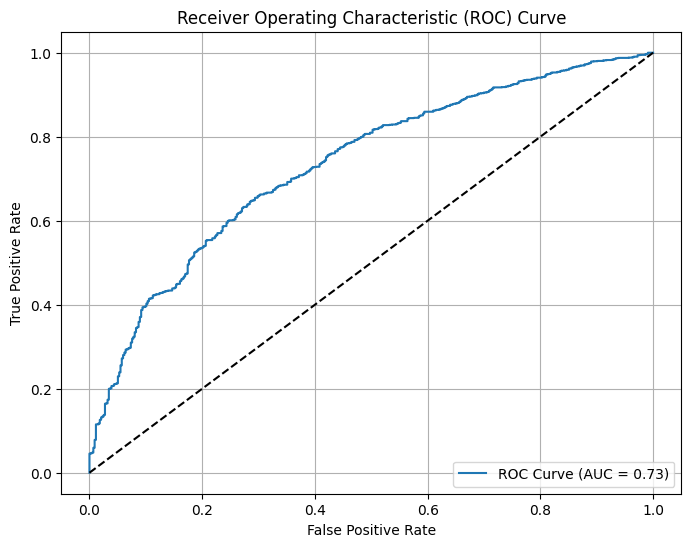

In [10]:
y_pred = best_overall_model.predict(X_test)
y_prob = best_overall_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred))
print("Confusion Matrix (Best Model):")
print(confusion_matrix(y_test, y_pred))
test_auc = roc_auc_score(y_test, y_prob)
print("Test ROC AUC (Best Model):", test_auc)

# Plot ROC Curve.
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# **Integration with Unsupervised Matching System (Nearest Neighbors)**

In [11]:
def get_ranked_matches(query_index, X_candidate_scaled_df, n_matches=5):
    """
    Given a query index from the full candidate features (X_candidate_scaled_df),
    returns the top n_matches (excluding the query itself) with their Euclidean distances.
    """
    matching_features = X_candidate_scaled_df.drop(columns=['Cluster'])
    from sklearn.neighbors import NearestNeighbors
    nn_model_full = NearestNeighbors(n_neighbors=n_matches+1, algorithm='auto')
    nn_model_full.fit(matching_features)
    distances, indices = nn_model_full.kneighbors(matching_features.iloc[[query_index]])
    neighbors_df = pd.DataFrame({
        'Neighbor_Index': indices[0],
        'Distance': distances[0]
    })
    ranked_matches = neighbors_df[neighbors_df['Distance'] > 0].reset_index(drop=True)
    return ranked_matches

# Example usage:
query_index_example = 1000
matches_example = get_ranked_matches(query_index_example, X_candidate_scaled_df, n_matches=5)
print(f"\nRanked matches for record index {query_index_example}:")
display(matches_example)



Ranked matches for record index 1000:


,Neighbor_Index,Distance
0,4814,0.026930
1,8906,0.047640
2,7896,0.076310
3,2901,0.076554
4,4371,0.076776


# **Save the Best Model and Other Objects**

In [12]:
import joblib

# Save the best overall model pipeline.
joblib.dump(best_overall_model, '/content/best_model_pipeline.pkl')
print("Saved best model pipeline as 'best_model_pipeline.pkl'.")




Saved best model pipeline as 'best_model_pipeline.pkl'.


In [13]:
# # Save the candidate scaler and clustering model.
# joblib.dump(scaler_candidate, '/content/scaler_candidate_features.pkl')
# joblib.dump(kmeans_model, '/content/kmeans_model.pkl')
# joblib.dump(X_candidate.columns.tolist(), '/content/candidate_feature_columns.pkl')
# print("Saved candidate features scaler, clustering model, and feature column names.")